In [1]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Below is a function that uses the DataSynthesizer package to generate $n$ samples of synthetic data. The full module can be found at `utils/gen_datasynthesizer.py`. The libarary also generates a JSON file that describes the distribution of all of the features, which gets used in `correlated` mode. However, we treat it as temporary and clean it up when the code finishes.

`independent` mode draws indepdently from each of the distributions of the individual features when sampling. While `correlated` constructs a Bayesian Network to relate the distributions of the features to one another, and the combined distribution that DataSynthesizer samples from correlates with all of the features at once.

In [10]:
"""
Generate synthetic tabular data using DataSynthesizer
"""
import argparse
import os
import pandas as pd
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator


def generate_synthetic_data(input_file, output_file, num_rows, mode='independent',
                           categorical_threshold=30, histogram_bins=10, 
                           max_parents=2, categorical_cols=None):
    """
    Generate synthetic data from input CSV file.
    
    Args:
        input_file: Path to input CSV file
        output_file: Path to save synthetic CSV
        num_rows: Number of synthetic rows to generate
        mode: 'independent' or 'correlated'
        categorical_threshold: Max unique values to treat as categorical
        histogram_bins: Number of bins for numeric distributions
        max_parents: Max parents in Bayesian network (correlated mode only)
        categorical_cols: List of column names to force as categorical
    """
    # Use temp description file
    description_file = f'.tmp_description_{os.getpid()}.json'
    
    try:
        # Build categorical attributes dict
        categorical_attributes = {}
        if categorical_cols:
            for col in categorical_cols:
                categorical_attributes[col] = True
        
        # Describe the dataset
        describer = DataDescriber(
            category_threshold=categorical_threshold,
            histogram_bins=histogram_bins
        )
        
        if mode == 'independent':
            describer.describe_dataset_in_independent_attribute_mode(
                dataset_file=input_file,
                attribute_to_is_categorical=categorical_attributes,
                attribute_to_is_candidate_key={}
            )
        elif mode == 'correlated':
            describer.describe_dataset_in_correlated_attribute_mode(
                dataset_file=input_file,
                epsilon=0,
                k=max_parents,
                attribute_to_is_categorical=categorical_attributes
            )
        else:
            raise ValueError(f"Invalid mode: {mode}. Use 'independent' or 'correlated'")
        
        describer.save_dataset_description_to_file(description_file)
        
        # Generate synthetic dataset
        generator = DataGenerator()
        
        if mode == 'independent':
            generator.generate_dataset_in_independent_mode(num_rows, description_file)
        else:  # correlated
            generator.generate_dataset_in_correlated_attribute_mode(num_rows, description_file)
        
        generator.save_synthetic_data(output_file)
        
    finally:
        # Clean up temp description file
        if os.path.exists(description_file):
            os.remove(description_file)



Lets make some synthetic penguins!

In [11]:
generate_synthetic_data(
    input_file='data/penguins.csv',
    output_file='data/synthetic_penguins.csv',
    num_rows=345, # Match dataset size
    mode='independent',
    categorical_cols=['species', 'island']
)


From looking at the rows of the output, it's quite easy to see that the synthetic data rows use much more precision than the original data!

Next, let's look at the distribution of the synthetic data by seeing what proportion of is is considered a near duplicate by our pipeline from Activity 2.

In [23]:
from utils.detect_duplicates import DuplicateDetector
import matplotlib.pyplot as plt
import numpy as np

In [27]:
thresholds = [0.9, 0.95, 0.97, 0.99, 1]   
results_orig = [] 
results_synth = [] 

for threshold in thresholds:
    detector = DuplicateDetector(
        similarity_threshold=threshold,
        n_clusters=None  # None means use sqrt-based dynamic clustering
    )

    # Original
    result_orig = detector.process_file(
        'data/penguins.csv',
        # create_deduplicated=True
    )

    # Synthetic
    result_synth = detector.process_file(
        'data/synthetic_penguins.csv',
        # create_deduplicated=True
    )

    results_orig.append(result_orig['to_remove'])
    results_synth.append(result_synth['to_remove'])

results_orig = np.array(results_orig)
results_synth = np.array(results_synth)

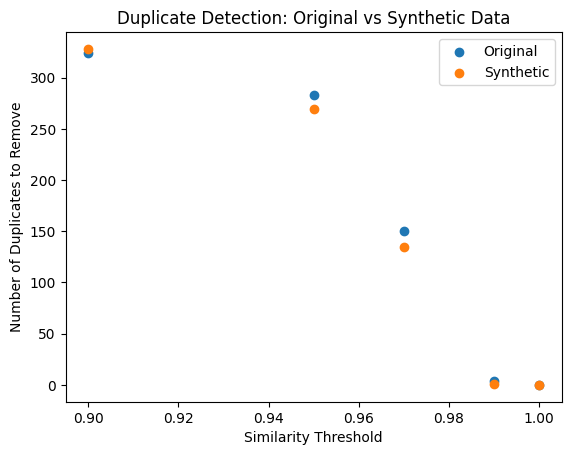

In [29]:
plt.scatter(thresholds, results_orig, label='Original')
plt.scatter(thresholds, results_synth, label='Synthetic')
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Duplicates to Remove')
plt.title('Duplicate Detection: Original vs Synthetic Data')
plt.legend()
plt.show()